Installing (updating) the following libraries for your Sagemaker
instance.

In [ ]:
!pip install .. # installing d2l


# Atenção de Bahdanau
:label:`sec_seq2seq_attention`


Nós estudamos a tradução automática
problema em :numref:`sec_seq2seq`,
onde projetamos
uma arquitetura de codificador-decodificador baseada em duas RNNs
para aprendizagem de sequência em sequência.
Especificamente,
o codificador de RNN
transforma
uma sequência de comprimento variável
em uma variável de contexto de forma fixa,
então
o decodificador de RNN
gera o token de sequência de saída (destino) por token
com base nos tokens gerados e na variável de contexto.
Contudo,
mesmo que nem todos os tokens de entrada (fonte)
são úteis para decodificar um certo token,
a *mesma* variável de contexto
que codifica toda a sequência de entrada
ainda é usada em cada etapa de decodificação.


Em um separado, mas relacionado
desafio de geração de caligrafia para uma determinada sequência de texto,
Graves projetou um modelo de atenção diferenciável
para alinhar caracteres de texto com o traço de caneta muito mais longo,
onde o alinhamento se move apenas em uma direção :cite:`Graves.2013`.
Inspirado pela ideia de aprender a alinhar,
Bahdanau et al. propôs um modelo de atenção diferenciável
sem a limitação severa de alinhamento unidirecional :cite:`Bahdanau.Cho.Bengio.2014`.
Ao prever um token,
se nem todos os tokens de entrada forem relevantes,
o modelo alinha (ou atende)
apenas para partes da sequência de entrada que são relevantes para a previsão atual.
Isso é alcançado
tratando a variável de contexto como uma saída do agrupamento de atenção.

## Modelo

Ao descrever
Atenção Bahdanau
para o codificador-decodificador RNN abaixo,
nós seguiremos a mesma notação em
:numref:`sec_seq2seq`.
O novo modelo baseado na atenção
é o mesmo que 
em :numref:`sec_seq2seq`
exceto que
a variável de contexto
$\mathbf{c}$
em
:eqref:`eq_seq2seq_s_t`
é substituída por
$\mathbf{c}_{t'}$
em qualquer passo de tempo de decodificação $t'$.
Suponha que
existem tokens $T$ na sequência de entrada,
a variável de contexto na etapa de tempo de decodificação $t'$
é o resultado do agrupamento de atenção:

$$\mathbf{c}_{t'} = \sum_{t=1}^T \alpha(\mathbf{s}_{t' - 1}, \mathbf{h}_t) \mathbf{h}_t,$$

onde o decodificador está escondido
$\mathbf{s}_{t' - 1}$ no passo de tempo $t' - 1$
é a consulta,
e os estados ocultos do codificador $\mathbf{h}_t$
são as chaves e os valores,
e o peso de atenção $\alpha$
é calculado como em
:eqref:`eq_attn-scoring-alpha`
usando a função de pontuação de atenção aditiva
definida por
:eqref:`eq_additive-attn`.


Um pouco diferente da arquitetura do codificador-decodificador Vanilla RNN
em :numref:`fig_seq2seq_details`,
a mesma arquitetura
com atenção de Bahdanau, é retratada em
:numref:`fig_s2s_attention_details`.

![Camadas em um modelo de codificador-decodificador RNN com atenção Bahdanau.](../img/seq2seq-attention-details.svg)
:label:`fig_s2s_attention_details`


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## Definindo o Decodificador com Atenção

Para implementar o codificador-decodificador RNN
com atenção Bahdanau,
só precisamos redefinir o decodificador.
Para visualizar os pesos de atenção aprendidos de forma mais conveniente,
a seguinte classe `AttentionDecoder`
define a interface base para
decodificadores com mecanismos de atenção.


In [2]:
#@save
class AttentionDecoder(d2l.Decoder):
    """The base attention-based decoder interface."""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

Agora vamos implementar
o decodificador RNN com atenção Bahdanau
na seguinte classe `Seq2SeqAttentionDecoder`.
O estado do decodificador
é inicializado com
i) os estados ocultos da camada final do codificador em todas as etapas de tempo (como chaves e valores da atenção);
ii) o estado oculto de todas as camadas do codificador na etapa de tempo final (para inicializar o estado oculto do decodificador);
e iii) o comprimento válido do codificador (para excluir os tokens de preenchimento no agrupamento de atenção).
Em cada etapa de tempo de decodificação,
o estado oculto da camada final do decodificador na etapa de tempo anterior é usado como a consulta da atenção.
Como resultado, tanto a saída de atenção
e a incorporação de entrada são concatenadas
como entrada do decodificador RNN.


In [3]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # Shape of `outputs`: (`num_steps`, `batch_size`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`,
        # `num_hiddens`)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of `enc_outputs`: (`batch_size`, `num_steps`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`,
        # `num_hiddens`)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output `X`: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of `query`: (`batch_size`, 1, `num_hiddens`)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # Shape of `context`: (`batch_size`, 1, `num_hiddens`)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape `x` as (1, `batch_size`, `embed_size` + `num_hiddens`)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully-connected layer transformation, shape of `outputs`:
        # (`num_steps`, `batch_size`, `vocab_size`)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

A seguir, testamos o
decodificador implementado com atenção Bahdanau
usando um minibatch de 4 entradas de sequência
de 7 etapas de tempo.


In [4]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (`batch_size`, `num_steps`)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

## Treinamento


Semelhante a :numref:`sec_seq2seq_training`,
aqui especificamos hiperparâmetros,
instanciamos
um codificador e um decodificador com atenção Bahdanau,
e treinamos este modelo para tradução automática.
Devido ao mecanismo de atenção recém-adicionado,
este treinamento é muito mais lento do que
que em :numref:`sec_seq2seq_training` sem mecanismos de atenção.


loss 0.021, 4700.2 tokens/sec on cuda:0


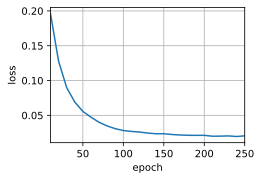

In [5]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

Depois que o modelo é treinado,
nós o usamos para traduzir algumas frases do inglês
para o francês e computar suas pontuações BLEU.


In [6]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est mouillé .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [7]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))

Visualizando os pesos de atenção
ao traduzir a última frase em inglês,
podemos ver que cada consulta atribui pesos não uniformes
sobre pares de valores-chave.
Isso mostra que em cada etapa de decodificação,
diferentes partes das sequências de entrada
são agregadas seletivamente no pool de atenção.


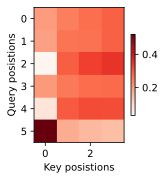

In [8]:
# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key posistions', ylabel='Query posistions')

## Resumo

* Ao prever um token, se nem todos os tokens de entrada forem relevantes, o codificador-decodificador RNN com atenção Bahdanau seletivamente agrega diferentes partes da sequência de entrada. Isso é obtido tratando a variável de contexto como uma saída do agrupamento de atenção aditiva.
* No codificador-decodificador RNN, a atenção Bahdanau trata o estado oculto do decodificador na etapa de tempo anterior como a consulta, e os estados ocultos do codificador em todas as etapas de tempo como as chaves e os valores.


## Exercícios

1. Substitua GRU por LSTM no experimento.
1. Modifique o experimento para substituir a função de pontuação de atenção aditiva pelo produto escalar escalonado. Como isso influencia a eficiência do treinamento?


[Discussions](https://discuss.d2l.ai/t/1065)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTEwMjQ1NzU5NTcsLTExMzU5Nzg4MTksLT
UxMDgzMjQzMiwtNDE2MTAzMDYzLDM0MTMyMzkyNiwxMzkxMTEz
OTIxXX0=
-->
